In [56]:
import numpy as np
from scipy import interp, stats, integrate
from sklearn import svm, datasets,metrics
from sklearn.metrics import roc_curve, auc,roc_auc_score,accuracy_score
from sklearn.model_selection import StratifiedKFold,LeaveOneOut,cross_val_score,train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.utils import shuffle,class_weight
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm 



from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,RandomTreesEmbedding,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import SelectKBest, chi2,SelectFromModel
import scipy.stats as st


import pickle,sys,glob,os
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, train_test_split,RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from numpy import random
import random

import matplotlib.pyplot as plt


In [57]:
def ploting_func(ax,aucs,tprs, mean_fpr):
    '''
    Plot the AUC with confdence interval
    '''
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0); #mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr);std_auc = np.std(aucs)

    CI_AUC = st.t.interval(0.95, len(aucs), loc=np.mean(aucs), scale=st.sem(aucs))
    ax.plot(mean_fpr, mean_tpr, color= 'Darkred', label =  r' (AUC = %0.2f  [%0.2f %0.2f])'
            % (mean_auc, CI_AUC[0],CI_AUC[1]), lw = 3, alpha=.99)

    std_tpr = np.std(tprs, axis = 0)    
    
    tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr/np.sqrt(ITERANTIONS*10), 1)
    tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr/np.sqrt(ITERANTIONS*10), 0)

    ax.fill_between(mean_fpr, tprs_upper, tprs_lower, color='gray', alpha=.3, label='95% CI')

    #plt.title('Receiver Operating Characteristic', ha='center', fontdict = font)
    plt.xlim([0., 1.0]); plt.ylim([0.0, 1.])
    

In [58]:
def compute_difMat(x, gamma):
    '''
    Difference between features of each participant
    '''
    mean_diff = []
    for ii in range(0,x.shape[0]):
        for jj in range(ii,x.shape[0]):
            if ii != jj:                                            
                Dif__ = diff_bn_parti(x[ii],x[jj])    
                mean_diff.append(Dif__)
                #print('Average', mean_diff)
   
    return(mean_diff)

def diff_bn_parti(p1,p2):  
    """
    The difference in the features of two trails
    """  
    p1_,p2_ = [], []    
    # access each video
    for ii in range(0,3):
        p1_.append(p1[(ii*116): (ii*116+116)])
        p2_.append(p2[(ii*116): (ii*116+116)])
        
    dif = []        
    for ii in range(0,3):            
        dif.append([LA.norm(np.array(p1_[ii]) - np.array(p2_[jj])) for jj in range(0,3)])
        
    Dif_ = np.array(dif)            
    Dif2 = Dif_[~np.isnan(Dif_)]     
    #print("Difference: ", Dif2)           
    averageX = 10000
    if len(Dif2):
        averageX = (np.mean([np.mean(Dif2),np.max(Dif2)]))
    
    return( averageX)  


In [59]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np
from numpy import linalg as LA
def fit_kpca(X, gamma, n_components):    
    """
    Fit KPCA to the data using a given parametres (gamma and n_components)
    """    
    sq_dists = compute_difMat(X,gamma)
    
    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)
    mat_sq_dists[mat_sq_dists == 0] = 1
    # Computing the MxM kernel matrix.
    K = np.exp(-gamma * mat_sq_dists)
    #K = mat_sq_dists
    
    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K_norm = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K_norm)

    # Obtaining the i eigenvectors (alphas) that corresponds to the i highest eigenvalues (lambdas).
    alphas = np.array([eigvecs[:,-i] for i in range(1,n_components+1)]).T
    lambdas = [eigvals[-i] for i in range(1,n_components+1)]

    return alphas, lambdas
    
def project_kpca(x_new, X, gamma, alphas, lambdas): 
    """
    Project a given vector to fit the KPCA 
    """  
    pair_dist = np.array([np.sum((diff_bn_parti(x_new,row))) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)



In [85]:
#f = plt.figure(num=None, figsize=(8,6), dpi=100, facecolor='w', edgecolor='k')
#ax = f.add_subplot(111)

np.random.seed(5); random.seed(5)

#@jit(parallel=True)
def Fit_the_model(Train_X__,Train_Y__,gamma_kpca,gamma_svm,c_):
    tprs, aucs = [], []
    #for it in range(0,itrs):
    for it in tqdm(range(ITERANTIONS)):         
        kfold = StratifiedKFold(n_splits = 10, random_state = None, shuffle = True)
        
        for train, test in kfold.split(Train_X__,Train_Y__):
            
            trainx = Train_X__[train];  Train_Y = Train_Y__[train]
            testx = Train_X__[test]; Valid_Y = Train_Y__[test]  
            
            # first fit using the training data and then transform project both training and test data
            # gamma = 200, n = 3 give auc = .7
            
            alphas, lambdas = fit_kpca(trainx, gamma = gamma_kpca, n_components = 2)
            trainx_proj = [];  testx_proj = []        
            
            for kk in range(0,trainx.shape[0]):
                trainx_proj.append(project_kpca(trainx[kk,:], trainx, gamma = gamma_kpca, alphas = alphas, lambdas = lambdas))
            
            for kk in range(0,testx.shape[0]):
                testx_proj.append(project_kpca(testx[kk,:], trainx, gamma = gamma_kpca, alphas = alphas, lambdas = lambdas))

            trainx = np.asarray(trainx_proj)        
            testx = np.asarray(testx_proj)

            trainx, Train_Y = shuffle(trainx, Train_Y, random_state = 0) 

            # define the model
            classifier = svm.SVC(kernel = 'rbf', gamma= gamma_svm, C = c_, probability = True, class_weight  = 'balanced')
        
            probas_ = classifier.fit(trainx, Train_Y.ravel()).predict_proba(testx)
            y_pred = classifier.predict(testx)    
            accuracy = accuracy_score(Valid_Y.ravel(), y_pred)
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(Valid_Y.ravel(), probas_[:, 1])
            roc_auc = auc(fpr, tpr)
            #print(f"Roc: {roc_auc}")
            
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0        
            aucs.append(roc_auc)
 
    return(np.mean(aucs))
    #print(np.mean(aucs))


In [61]:
# accessing the processed features
PathToFiles = "../Features_Based_ON_Paper"
n_folds = 10
fold_step = int(70 / n_folds)

mean_fpr = np.linspace(0, 1, 100)

Train_X__ = np.zeros((70, 116*3))
Train_Y__ = np.zeros((70,1))

NpyFiles =  glob.glob(os.path.join(PathToFiles, '*.npy'))
for ii in range(0,70):
    
    re  = np.load(NpyFiles[ii],allow_pickle=True)
    X = np.asarray(re.item().get('X')).flatten()
    Y = np.asarray(re.item().get('Y')).flatten()
    Train_X__[ii,:] = X
    Train_Y__[ii,:] =Y[0]

In [86]:
Gamma_Kpcas = [100,200,300,1000]
Gamma_SVMs = [0.001,0.01,0.1,1,10,200,300,1000]
Cs = [ 0.001,0.1,1.,10,100,300,1000]

ITERANTIONS = 3

for gamma_kpca in Gamma_Kpcas:
    for gamma_svm in Gamma_SVMs:
        for C in Cs:
            Avg_AUC = Fit_the_model(Train_X__,Train_Y__,gamma_kpca,gamma_svm,C)
            if Avg_AUC >.65:
                print(f"  gamma_kpca: {gamma_kpca}, gamma_svm: {gamma_svm}, and C: {C}, {Avg_AUC}")

100%|██████████| 3/3 [00:20<00:00,  6.84s/it]


In [ ]:
# n =2
gamma_kpca: 200, gamma_svm: 1000, and C: 0.001, 0.7138888888888889
100, gamma_svm: 1000, and C: 1.0, 0.6972222222222222
amma_kpca: 100, gamma_svm: 0.01, and C: 300
gamma_kpca: 100, gamma_svm: 1000, and C: 0.001, 0.7083333333333334
gamma_kpca: 100, gamma_svm: 1000, and C: 0.001, 0.7347222222222222
 gamma_kpca: 100, gamma_svm: 300, and C: 0.001, 0.7305555555555556
 gamma_kpca: 100, gamma_svm: 200, and C: 0.001, 0.7083333333333334
 gamma_kpca: 200, gamma_svm: 300, and C: 1.0, 0.7208333333333332

100%|██████████| 10/10 [01:08<00:00,  6.82s/it][0.41666666666666663, 0.5, 0.375, 0.16666666666666669, 1.0, 0.9166666666666667, 0.7500000000000001, 0.75, 0.6666666666666666, 0.5833333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.4166666666666667, 0.9166666666666667, 0.6666666666666667, 0.8333333333333334, 1.0, 0.8333333333333334, 0.5, 0.25, 0.8333333333333334, 0.9166666666666667, 0.6666666666666667, 0.8333333333333334, 0.75, 0.5, 0.9166666666666667, 0.5833333333333334, 0.6666666666666666, 1.0, 0.9166666666666667, 0.9166666666666667, 0.7500000000000001, 0.9166666666666667, 0.4166666666666667, 0.5, 0.37500000000000006, 0.6666666666666667, 1.0, 0.9166666666666666, 0.75, 0.6666666666666667, 0.6666666666666666, 0.5833333333333334, 0.8333333333333334, 0.3333333333333333, 1.0, 0.75, 0.8333333333333334, 0.5833333333333334, 0.3333333333333333, 0.6666666666666667, 0.75, 0.7500000000000001, 1.0, 1.0, 0.8333333333333334, 0.6666666666666667, 0.833333333

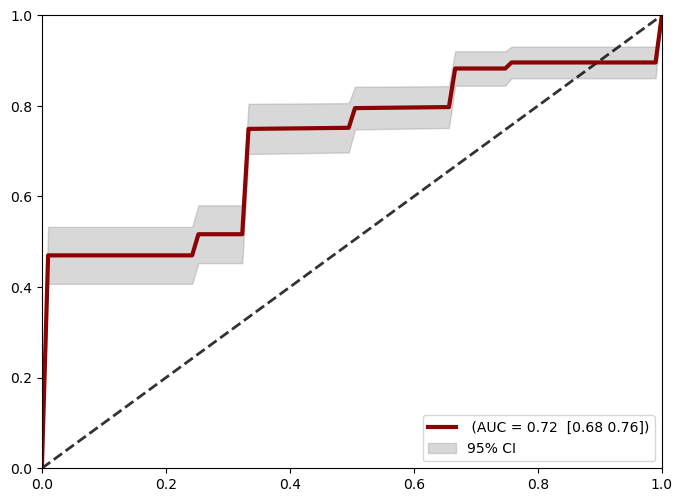

In [93]:
f = plt.figure(num=None, figsize=(8,6), dpi=100, facecolor='w', edgecolor='k')
ax = f.add_subplot(111)

np.random.seed(5); random.seed(5)

gamma_kpca = 100; gamma_svm = 1000; c_ = .001
tprs, aucs = [], []
ITERANTIONS = 10
#for it in range(0,itrs):
for it in tqdm(range(ITERANTIONS)):         
    kfold = StratifiedKFold(n_splits = 10, random_state = None, shuffle = True)
    
    for train, test in kfold.split(Train_X__,Train_Y__):
        
        trainx = Train_X__[train];  Train_Y = Train_Y__[train]
        testx = Train_X__[test]; Valid_Y = Train_Y__[test]  
        
        alphas, lambdas = fit_kpca(trainx, gamma = gamma_kpca, n_components = 2)
        trainx_proj = [];  testx_proj = []        
        
        for kk in range(0,trainx.shape[0]):
            trainx_proj.append(project_kpca(trainx[kk,:], trainx, gamma = gamma_kpca, alphas = alphas, lambdas = lambdas))
        
        for kk in range(0,testx.shape[0]):
            testx_proj.append(project_kpca(testx[kk,:], trainx, gamma = gamma_kpca, alphas = alphas, lambdas = lambdas))

        trainx = np.asarray(trainx_proj)        
        testx = np.asarray(testx_proj)

        trainx, Train_Y = shuffle(trainx, Train_Y, random_state = 0) 

        # define the model
        classifier = svm.SVC(kernel = 'rbf', gamma= gamma_svm, C = c_, probability = True, class_weight  = 'balanced')
    
        probas_ = classifier.fit(trainx, Train_Y.ravel()).predict_proba(testx)
        y_pred = classifier.predict(testx)    
        accuracy = accuracy_score(Valid_Y.ravel(), y_pred)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Valid_Y.ravel(), probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        #print(f"Roc: {roc_auc}")
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0        
        aucs.append(roc_auc)      

ploting_func(ax,aucs,tprs, mean_fpr)
plt.legend(loc="lower right")
plt.show
print(aucs)
